## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [ ]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Standard MNIST normalization
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [33]:
task_definitions = {
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}

def create_task_datasets(dataset, task_classes, n_train=100, n_support=5, n_query=10):

    indices = [i for i, (_, label) in enumerate(dataset) if label in task_classes]
    random.shuffle(indices)


    class_0 = task_classes[0]
    class_1 = task_classes[1]

    idx_c0 = [i for i in indices if dataset[i][1] == class_0]
    idx_c1 = [i for i in indices if dataset[i][1] == class_1]

    support_idx = idx_c0[:n_support] + idx_c1[:n_support]
    query_idx = idx_c0[n_support:n_support+n_query] + idx_c1[n_support:n_support+n_query]

    train_idx = idx_c0[n_support+n_query:n_support+n_query+n_train] + \
                idx_c1[n_support+n_query:n_support+n_query+n_train]

    # Create Subsets
    train_subset = Subset(dataset, train_idx)
    support_subset = Subset(dataset, support_idx)
    query_subset = Subset(dataset, query_idx)

    return train_subset, support_subset, query_subset

# Test the split
train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'], n_train=1000)
print(f"Task A (0,1) - Train (Large): {len(train_A)}, Support (Few-Shot): {len(support_A)}, Query: {len(query_A)}")

Task A (0,1) - Train (Large): 2000, Support (Few-Shot): 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        # Feature Extractor (Convolutional Blocks)
        self.features = nn.Sequential(
            # Block 1: 1x28x28 -> 16x14x14
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2: 16x14x14 -> 32x7x7
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Classifier (Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def map_labels_to_binary(labels, task_classes):
    new_labels = labels.clone()
    for i, c in enumerate(task_classes):
        new_labels[labels == c] = i
    return new_labels

In [35]:
def train_epoch(model, loader, optimizer, criterion, task_classes=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        if task_classes:
            labels = map_labels_to_binary(labels, task_classes)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total

def evaluate(model, loader, task_classes=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            if task_classes:
                labels = map_labels_to_binary(labels, task_classes)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [36]:
import copy
train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'], n_train=2000)
loader_A_large = DataLoader(train_A, batch_size=32, shuffle=True)
loader_support_A = DataLoader(support_A, batch_size=5, shuffle=True)
loader_query_A = DataLoader(query_A, batch_size=10, shuffle=False)

print("Method 1: Training Task A Model")
model_A = SimpleCNN(num_classes=2).to(device)
optimizer = optim.Adam(model_A.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history_method_1 = []
for epoch in range(5):
    loss, acc = train_epoch(model_A, loader_A_large, optimizer, criterion, task_definitions['A'])
    history_method_1.append(acc)
    print(f"Epoch {epoch+1}: Loss {loss:.4f}, Acc {acc:.2f}%")

robust_A_state = copy.deepcopy(model_A.state_dict())

Method 1: Training Task A Model
Epoch 1: Loss 0.0331, Acc 98.53%
Epoch 2: Loss 0.0036, Acc 99.90%
Epoch 3: Loss 0.0041, Acc 99.88%
Epoch 4: Loss 0.0005, Acc 99.97%
Epoch 5: Loss 0.0001, Acc 100.00%


In [37]:
print("Method 2.1: Random Init + Fine-tune on Support A")
model_rand = SimpleCNN(num_classes=2).to(device)
optimizer = optim.Adam(model_rand.parameters(), lr=0.001)

history_2_1 = []
for epoch in range(20):
    loss, acc = train_epoch(model_rand, loader_support_A, optimizer, criterion, task_definitions['A'])
    history_2_1.append(acc)

acc_2_1 = evaluate(model_rand, loader_query_A, task_definitions['A'])
print(f"Final Test Accuracy (Query A): {acc_2_1:.2f}%")

Method 2.1: Random Init + Fine-tune on Support A
Final Test Accuracy (Query A): 100.00%


In [38]:
print("\Method 2.2: Transfer (Robust A -> Support B)")
train_B, support_B, query_B = create_task_datasets(train_dataset, task_definitions['B'])
loader_support_B = DataLoader(support_B, batch_size=5, shuffle=True)
loader_query_B = DataLoader(query_B, batch_size=10, shuffle=False)

model_transfer = SimpleCNN(num_classes=2).to(device)
model_transfer.load_state_dict(robust_A_state)
model_transfer.classifier[3] = nn.Linear(128, 2).to(device)

optimizer = optim.Adam(model_transfer.parameters(), lr=0.0005)

history_2_2 = []
for epoch in range(20):
    loss, acc = train_epoch(model_transfer, loader_support_B, optimizer, criterion, task_definitions['B'])
    history_2_2.append(acc)

acc_2_2 = evaluate(model_transfer, loader_query_B, task_definitions['B'])
print(f"Final Test Accuracy (Query B): {acc_2_2:.2f}%")

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-3623005136.py:1: SyntaxWarning: invalid escape sequence '\M'
  print("\Method 2.2: Transfer (Robust A -> Support B)")


\Method 2.2: Transfer (Robust A -> Support B)
Final Test Accuracy (Query B): 100.00%


In [39]:
print("\Method 2.3: Pre-train All (10-way) -> Fine-tune Support A")
loader_all = DataLoader(train_dataset, batch_size=64, shuffle=True)
model_10 = SimpleCNN(num_classes=10).to(device)
opt_10 = optim.Adam(model_10.parameters(), lr=0.001)

print("Pre-training on all MNIST")
for epoch in range(3):
    train_epoch(model_10, loader_all, opt_10, criterion)

model_10.classifier[3] = nn.Linear(128, 2).to(device)
optimizer = optim.Adam(model_10.parameters(), lr=0.0005)

history_2_3 = []
for epoch in range(20):
    loss, acc = train_epoch(model_10, loader_support_A, optimizer, criterion, task_definitions['A'])
    history_2_3.append(acc)

acc_2_3 = evaluate(model_10, loader_query_A, task_definitions['A'])
print(f"Final Test Accuracy (Query A): {acc_2_3:.2f}%")

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-3333742639.py:1: SyntaxWarning: invalid escape sequence '\M'
  print("\Method 2.3: Pre-train All (10-way) -> Fine-tune Support A")


\Method 2.3: Pre-train All (10-way) -> Fine-tune Support A
Pre-training on all MNIST
Final Test Accuracy (Query A): 100.00%


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

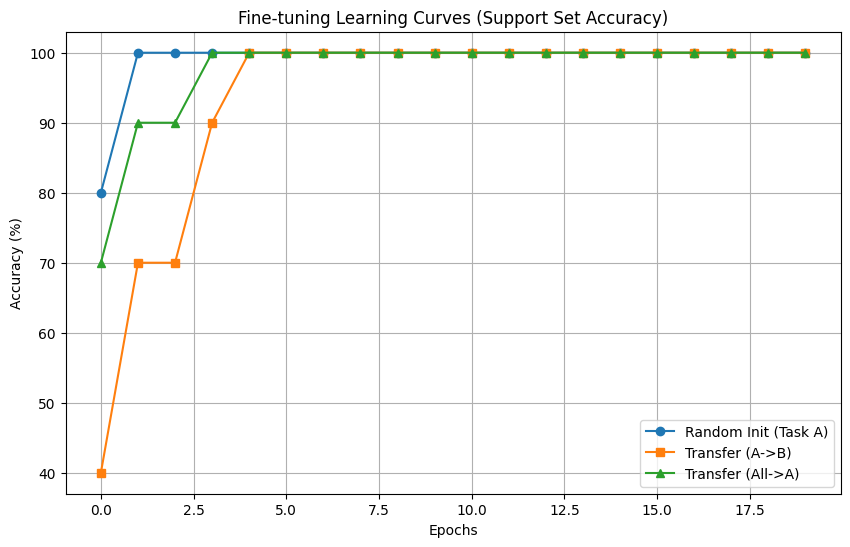


--- Summary Results (Query Set Accuracy) ---
Method 2.1 (Random Init): 100.00%
Method 2.2 (Transfer A->B): 100.00%
Method 2.3 (Transfer All->A): 100.00%


In [40]:
# Comparison Plot
plt.figure(figsize=(10, 6))
plt.plot(history_2_1, label='Random Init (Task A)', marker='o')
plt.plot(history_2_2, label='Transfer (A->B)', marker='s')
plt.plot(history_2_3, label='Transfer (All->A)', marker='^')
plt.title('Fine-tuning Learning Curves (Support Set Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Summary Results (Query Set Accuracy) ---")
print(f"Method 2.1 (Random Init): {acc_2_1:.2f}%")
print(f"Method 2.2 (Transfer A->B): {acc_2_2:.2f}%")
print(f"Method 2.3 (Transfer All->A): {acc_2_3:.2f}%")

Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



Question 1. Strategy 2.2 (Fine-tuning Task A model on Task B) works significantly better than Strategy 2.1 (Random Initialization) because this is due to Feature Reuse. In Strategy 2.1, the model starts with random weights and tries to learn complex visual features (edges, curves) from only 5-10 images, leading to overfitting (high variance). In Strategy 2.2, the model loads weights from Task A. Since digits 0–1 share visual properties (lines, loops) with digits 2–3, the model reuses these pre-learned "feature detectors" and only needs to learn the final classification boundary, which requires much less data.

Question 2. While the Feature Extractor (convolutional layers) has seen the data, the Classification Head (the final linear layer) has changed. We replace the 10-neuron output layer (for digits 0–9) with a new 2-neuron output layer (binary).

This new layer starts with random weights.

"Fine-tuning" is essentially calibrating this new final layer to map the high-quality, pre-existing features to the new binary labels. It aligns the existing knowledge with the new specific task definition.

Question 3 It will work to some extent because low-level features (vertical lines, curves) are universal between digits and letters. However, high-level features (complex shapes specific to numbers) may not transfer perfectly.

How to make it work: Instead of freezing the entire feature extractor, you should unfreeze the last 1 or 2 convolutional layers. This allows the model to "adapt" its high-level shape detectors from digit-specific shapes to letter-specific shapes (Domain Adaptation) while still keeping the useful low-level edge detectors frozen.

Question 4 We have not used Meta-Learning in this experiment. We used Transfer Learning. Transfer Learning: Trains a model to be good at Task A, hoping the features are useful for Task B. Meta-Learning (e.g., MAML): Explicitly trains the model to find an initialization that is "easy to fine-tune" for any future task. The training objective is different (optimizing for adaptability rather than immediate accuracy).

# ALL THE BEST !